In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1> Importing Libraries </h1>

In [ ]:
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timm
from torch import nn, optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm

<h2> Loading Datasets </h2>

In [3]:
sources = {
    #"Dataset 1 - TB":  (Path("/content/drive/MyDrive/Dataset1/TB Chest X-rays"), 1),
    "Dataset 2 - TB":  (Path("/content/drive/MyDrive/Dataset2/Tuberculosis"), 1),
    "Dataset 3 - TB":  (Path("/content/drive/MyDrive/Dataset3/imgs/tb"), 1),
    "Dataset 4 - TB":  (Path("/content/drive/MyDrive/Dataset4/TURBERCULOSIS"), 1),

    "Dataset 1 - Normal":  (Path("/content/drive/MyDrive/Dataset1/Normal Chest X-rays"), 0),
    #"Dataset 2 - Normal":  (Path("/content/drive/MyDrive/Dataset2/Normal"), 0),
    #"Dataset 3 - Normal":  (Path("/content/drive/MyDrive/Dataset3/imgs/health"), 0),
    "Dataset 4 - Normal":  (Path("/content/drive/MyDrive/Dataset4/NORMAL"), 0),
}


In [4]:
#pip install torch torchvision timm matplotlib scikit-learn

<h2> Doing Transformations </h2>
1. Resizing <br>
2. Normalize

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

<h2> Pre-Processing Dataset </h2>
Splitting into Train, Validation and Test dataset

In [9]:
# 3. Custom dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, sources_dict, transform=None):
        self.data = []
        self.transform = transform

        for _, (folder_path, label) in sources_dict.items():
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = folder_path / img_name
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# 4. Create dataset and DataLoader
full_dataset = ChestXrayDataset(sources, transform=transform)

# Optional: split into train/test
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(full_dataset)))
temp_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=[label for _, label in full_dataset.data])

train_idx, val_idx = train_test_split(temp_idx, test_size=0.2, random_state=42, stratify=[full_dataset.data[i][1] for i in temp_idx])

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<h2> Printing Sample Images </h2>

Displaying example images from the training dataset:


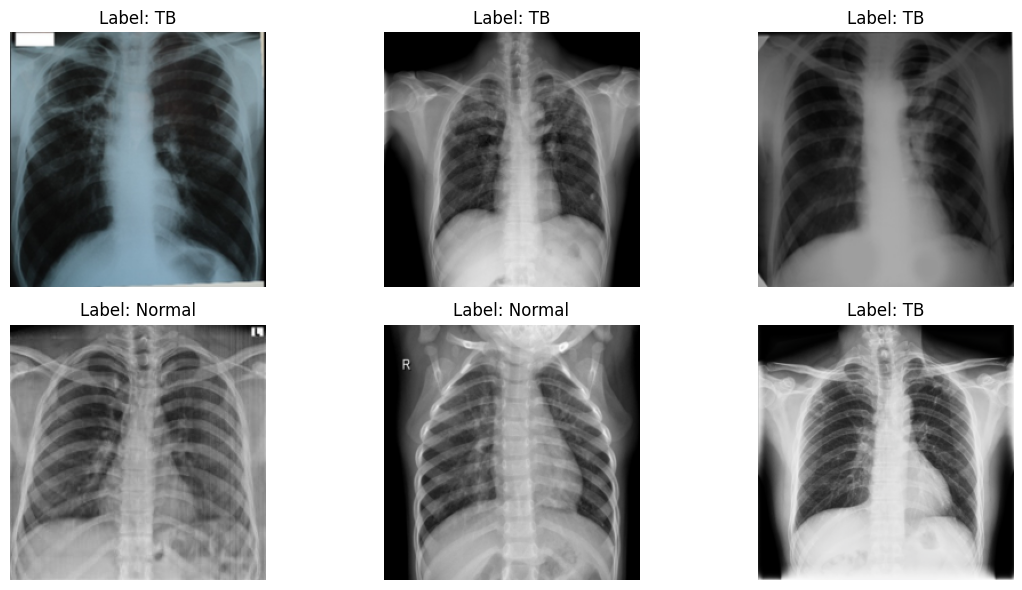

In [10]:
# Function to display a few example images from the training dataset
def show_sample_images(dataset, class_names=["Normal", "TB"], num_samples=6):
    plt.figure(figsize=(12, 6))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_samples):
        image, label = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()

        # Unnormalize
        image_np = (image_np * std) + mean
        image_np = image_np.clip(0, 1)

        plt.subplot(2, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"Label: {class_names[label.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from the training subset
print("Displaying example images from the training dataset:")
show_sample_images(train_dataset)

<h2> Loading Pre-trained Model and Fine Tuning </h2>

In [11]:
# 2. Load the pre-trained Swin Transformer model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)  # Swin-Tiny variant

# 3. Move model to device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only pass parameters that require gradients to the optimizer
optimizer = optim.Adam(model.head.parameters(), lr=1e-4)

# Initialize lists to store training and validation loss/accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 5. Training Loop
epochs = 2  # Set number of epochs to fine-tune
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training loop with tqdm progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", unit="batch")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)  # Ensure data is on the same device

        optimizer.zero_grad()  # Zero gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        running_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

        # Update progress bar description
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=correct_preds / total_preds * 100)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop with tqdm progress bar
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} Validation", unit="batch")
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)  # Ensure data is on the same device
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            # Update progress bar description
            val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=correct_preds / total_preds * 100)

    val_loss /= len(val_loader)
    val_accuracy = correct_preds / total_preds * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation statistics for the epoch
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/2 Validation: 100%|██████████| 22/22 [07:34<00:00, 20.66s/batch, accuracy=94.3, loss=0.338]


Epoch [1/2], Train Loss: 0.4805, Train Accuracy: 85.34%, Val Loss: 0.3313, Val Accuracy: 94.33%


Epoch 2/2 Validation: 100%|██████████| 22/22 [00:15<00:00,  1.39batch/s, accuracy=96.8, loss=0.217]

Epoch [2/2], Train Loss: 0.2959, Train Accuracy: 95.09%, Val Loss: 0.2213, Val Accuracy: 96.80%


<h2> Evaluating Model </h2>

In [13]:
def evaluate_model(model, dataloader, criterion, class_names=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    test_loss = 0.0

    test_loader_tqdm = tqdm(dataloader, desc=" Testing", unit="batch")

    with torch.no_grad():
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loader_tqdm.set_postfix(loss=loss.item())

    # Metrics
    test_loss /= len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

<h2> Testing on Test Dataset </h2>

 Testing: 100%|██████████| 27/27 [09:40<00:00, 21.52s/batch, loss=0.203]


Test Loss: 0.2156
Accuracy: 96.28%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9732    0.9500    0.9614       420
          TB     0.9533    0.9750    0.9640       440

    accuracy                         0.9628       860
   macro avg     0.9633    0.9625    0.9627       860
weighted avg     0.9630    0.9628    0.9628       860



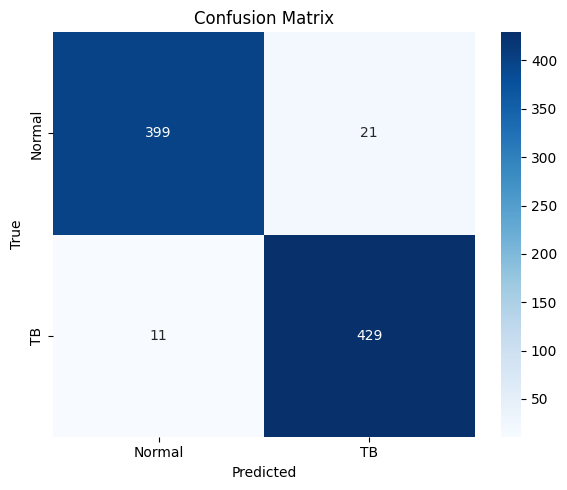

In [14]:
class_names = ['Normal', 'TB']

# Evaluate on test set
evaluate_model(model, test_loader, criterion=criterion, class_names=class_names, device=device)

<h2> Saving Model </h2>

In [15]:
# Save model weights and optimizer state
model_save_path = "swin_tb_detection_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to swin_tb_detection_model.pth
